<a href="https://colab.research.google.com/github/jpbeccaria/Playroom/blob/main/Decision_Tree_from_the_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Queremos clasificar especies de hongos segun su peligro a ser ingerido partir de algunas de sus caracteristicas externas.

Sabemos su color: marron o rojo
Forma del "tallo": \/ o  /\
Y si crece solitario o en grupo ()

Finalmente si es venenoso o no. En la imagen debajo se encuetra resumido el dataset

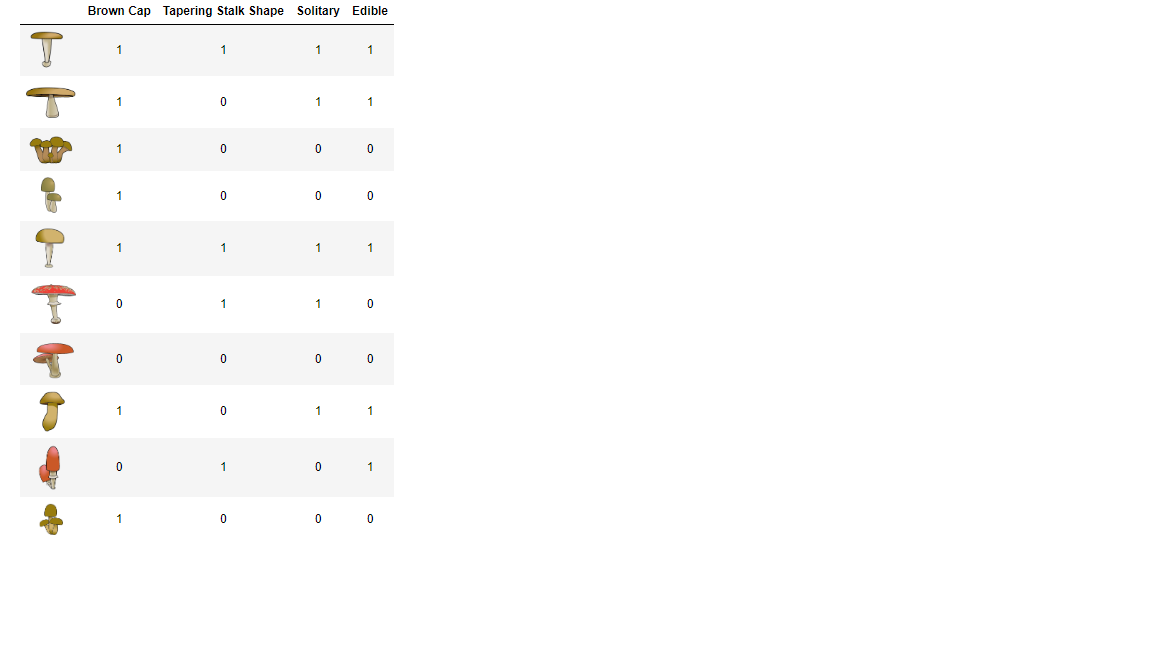

Vamos a resolverlo creando un árbol de desicion "a mano" sin usar bibliotecas de alto nivel

In [2]:
import numpy as np
import matplotlib.pyplot as plt
# from public_tests import *
# from utils import *

# %matplotlib inline

In [3]:
X_train = np.array([[1,1,1],[1,0,1],[1,0,0],[1,0,0],[1,1,1],[0,1,1],[0,0,0],[1,0,1],[0,1,0],[1,0,0]])
y_train = np.array([1,1,0,0,1,0,0,1,1,0])

In [4]:
print("First few elements of X_train:\n", X_train[:5])
print("Type of X_train:",type(X_train))

First few elements of X_train:
 [[1 1 1]
 [1 0 1]
 [1 0 0]
 [1 0 0]
 [1 1 1]]
Type of X_train: <class 'numpy.ndarray'>


In [5]:
print("First few elements of y_train:", y_train[:5])
print("Type of y_train:",type(y_train))

First few elements of y_train: [1 1 0 0 1]
Type of y_train: <class 'numpy.ndarray'>


In [6]:
print ('The shape of X_train is:', X_train.shape)
print ('The shape of y_train is: ', y_train.shape)
print ('Number of training examples (m):', len(X_train))

The shape of X_train is: (10, 3)
The shape of y_train is:  (10,)
Number of training examples (m): 10


In [16]:
# Empezamos creando una funcion para medir la entropia de un nodo / rama a parir de los la presencia de casos positivos y el total de casos

def compute_entropy(y):
    """
    Computes the entropy for 
    
    Args:
       y (ndarray): Numpy array indicating whether each example at a node is
           edible (`1`) or poisonous (`0`)
       
    Returns:
        entropy (float): Entropy at that node
        
    """
    entropy = 0.
    # Para definir la proporcion de casos positivos necesitamos los casos positivos y el total
    counter_comestibles = 0
    if len(y) != 0:
        for e in y:
            if e == 1:
                counter_comestibles += 1   #         
        p1 = counter_comestibles / len(y)

        # El log de 0 es indeterminado, asi que lo salvamos

        if p1 == 0 or p1 == 1:
            return 0
        else:      # en todos los demas casos, calculamos la entropia
            entropy = -p1 * np.log2(p1) - (1- p1) * np.log2((1-p1))     
            return entropy
    else:
        return entropy


In [8]:
# Creamos una funcion que sea capaz de dividir en ramas a partir de una lista de casos inicial y una feature en analisis que se evaluará

def split_dataset(X, node_indices, feature):
    """
    Splits the data at the given node into
    left and right branches
    
    Args:
        X (ndarray):             Data matrix of shape(n_samples, n_features)
        node_indices (list):     List containing the active indices. I.e, the samples being considered at this step.
        feature (int):           Index of feature to split on
    
    Returns:
        left_indices (list):     Indices with feature value == 1
        right_indices (list):    Indices with feature value == 0
    """
    
    left_indices = []
    right_indices = []
    
    
    for i in node_indices:   
        if X[i][feature] == 1:
            left_indices.append(i)
        else:
            right_indices.append(i)

        
    return left_indices, right_indices

In [9]:
## Creamos una funcion que calcula la information gain (caida de entropia) media entre las 2 ramas y su nodo raiz

def compute_information_gain(X, y, node_indices, feature):
    
    """
    Compute the information of splitting the node on a given feature
    
    Args:
        X (ndarray):            Data matrix of shape(n_samples, n_features)
        y (array like):         list or ndarray with n_samples containing the target variable
        node_indices (ndarray): List containing the active indices. I.e, the samples being considered in this step.
   
    Returns:
        cost (float):        Cost computed
    
    """    
    # Split dataset
    left_indices, right_indices = split_dataset(X, node_indices, feature)
    
    # Some useful variables
    X_node, y_node = X[node_indices], y[node_indices]
    X_left, y_left = X[left_indices], y[left_indices]
    X_right, y_right = X[right_indices], y[right_indices]
    
    # You need to return the following variables correctly
    information_gain = 0
    
    ### START CODE HERE ###

    entropy_node = compute_entropy(y_node) 
    entropy_left = compute_entropy(y_left)
    entropy_rigth = compute_entropy(y_right)
    
    w_left = len(y_left)/len(y_node)
    w_right = len(y_right)/len(y_node)
    
    information_gain = entropy_node - (w_left  * entropy_left + w_right * entropy_rigth)
    
    
# w_left = len(X_left) / len(X_node)
# w_right = len(X_right) / len(X_node)
    

    
    ### END CODE HERE ###  
    
    return information_gain

In [10]:
# Funcion para elegir la feature que genera la mejor information gain

def get_best_split(X, y, node_indices):   
    """
    Returns the optimal feature and threshold value
    to split the node data 
    
    Args:
        X (ndarray):            Data matrix of shape(n_samples, n_features)
        y (array like):         list or ndarray with n_samples containing the target variable
        node_indices (ndarray): List containing the active indices. I.e, the samples being considered in this step.

    Returns:
        best_feature (int):     The index of the best feature to split
    """    
    
    # Some useful variables
    num_features = X.shape[1]
    
    # You need to return the following variables correctly
    best_feature = -1
    value = 0
    
    ### START CODE HERE ###
    for feature in range(num_features):
        value_feature = compute_information_gain(X, y, node_indices, feature)
        if value_feature > value:
            value = value_feature
            best_feature = feature
            
            
            
    ### END CODE HERE ##    
   
    return best_feature

In [11]:
# Construimos el arbol a partir de un uso recursivo de las funciones anteriores.

tree = []

def build_tree_recursive(X, y, node_indices, branch_name, max_depth, current_depth):
    """
    Build a tree using the recursive algorithm that split the dataset into 2 subgroups at each node.
    This function just prints the tree.
    
    Args:
        X (ndarray):            Data matrix of shape(n_samples, n_features)
        y (array like):         list or ndarray with n_samples containing the target variable
        node_indices (ndarray): List containing the active indices. I.e, the samples being considered in this step.
        branch_name (string):   Name of the branch. ['Root', 'Left', 'Right']
        max_depth (int):        Max depth of the resulting tree. 
        current_depth (int):    Current depth. Parameter used during recursive call.
   
    """ 

    # Maximum depth reached - stop splitting
    if current_depth == max_depth:
        formatting = " "*current_depth + "-"*current_depth
        print(formatting, "%s leaf node with indices" % branch_name, node_indices)
        return
   
    # Otherwise, get best split and split the data
    # Get the best feature and threshold at this node
    best_feature = get_best_split(X, y, node_indices) 
    
    formatting = "-"*current_depth
    print("%s Depth %d, %s: Split on feature: %d" % (formatting, current_depth, branch_name, best_feature))
    
    # Split the dataset at the best feature
    left_indices, right_indices = split_dataset(X, node_indices, best_feature)
    tree.append((left_indices, right_indices, best_feature))
    
    # continue splitting the left and the right child. Increment current depth
    build_tree_recursive(X, y, left_indices, "Left", max_depth, current_depth+1)
    build_tree_recursive(X, y, right_indices, "Right", max_depth, current_depth+1)

In [19]:
root_indices = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

build_tree_recursive(X_train, y_train, root_indices, "Root", max_depth=2, current_depth=0)

print("=)")


 Depth 0, Root: Split on feature: 2
- Depth 1, Left: Split on feature: 0
  -- Left leaf node with indices [0, 1, 4, 7]
  -- Right leaf node with indices [5]
- Depth 1, Right: Split on feature: 1
  -- Left leaf node with indices [8]
  -- Right leaf node with indices [2, 3, 6, 9]
=)
